# Random Forest

In [1]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
import pickle
import os
os.chdir('/sietch_colab/akapoor/Demographic_Inference/')
from src.utils import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint


In [2]:
experiment_directory = '/sietch_colab/akapoor/Demographic_Inference/model2_results/Random_Forest/'
os.makedirs(experiment_directory, exist_ok=True)

In [3]:
# Import data
with open('/sietch_colab/akapoor/Demographic_Inference/model2_results/features_and_targets.pkl', 'rb') as f:
    features_and_targets = pickle.load(f)

In [4]:
# Define the parameter distributions for random search
param_distributions = {
    'estimator__n_estimators': randint(100, 500),  # Uniform integer between 100 and 500
    'estimator__max_depth': [None] + list(randint(10, 50).rvs(5)),  # None and 5 random integers between 10 and 50
    'estimator__min_samples_split': randint(2, 20),  # Uniform integer between 2 and 20
    'estimator__min_samples_leaf': randint(1, 10),  # Uniform integer between 1 and 10
    'estimator__max_features': uniform(0.5, 0.5)  # Uniform float between 0.5 and 1.0
}

# Create the base Random Forest regressor
base_rf = RandomForestRegressor(
    n_jobs=-1,                # Use all CPU cores
    random_state=42           # For reproducibility
)

# Create the MultiOutputRegressor
multioutput_rf = MultiOutputRegressor(base_rf)

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=multioutput_rf,
    param_distributions=param_distributions,
    n_iter=100,              # Number of parameter settings sampled
    cv=5,                    # 5-fold cross-validation
    scoring='neg_mean_squared_error',
    n_jobs=-1,              # Use all CPU cores
    verbose=2,              # Print progress
    random_state=42         # For reproducibility
)

# Fit the random search to find the best parameters
print("Starting random search...")
random_search.fit(
    features_and_targets['training']['features'],
    features_and_targets['training']['targets']
)

# Print the best parameters and score
print("\nBest parameters found:")
print(random_search.best_params_)
print("\nBest cross-validation score:", -random_search.best_score_)

# Get the best model
best_model = random_search.best_estimator_

# Make predictions with the best model
train_predictions = best_model.predict(features_and_targets['training']['features'])
val_predictions = best_model.predict(features_and_targets['validation']['features'])

# Calculate MSE for each target variable
train_mse = mean_squared_error(
    features_and_targets['training']['targets'],
    train_predictions
)
val_mse = mean_squared_error(
    features_and_targets['validation']['targets'],
    val_predictions
)

# Store all results in a dictionary
results = {
    'best_model': best_model,
    'best_params': random_search.best_params_,
    'cv_score': -random_search.best_score_,
    'train_mse': train_mse,
    'validation_mse': val_mse,
    'random_search': random_search  # Keep the full random search results
}

Starting random search...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END estimator__max_depth=20, estimator__max_features=0.9010984903770198, estimator__min_samples_leaf=1, estimator__min_samples_split=8, estimator__n_estimators=108; total time= 1.3min
[CV] END estimator__max_depth=20, estimator__max_features=0.9010984903770198, estimator__min_samples_leaf=1, estimator__min_samples_split=8, estimator__n_estimators=108; total time= 1.4min
[CV] END estimator__max_depth=36, estimator__max_features=0.7698460661945399, estimator__min_samples_leaf=8, estimator__min_samples_split=14, estimator__n_estimators=140; total time= 1.4min
[CV] END estimator__max_depth=36, estimator__max_features=0.5233328316068078, estimator__min_samples_leaf=3, estimator__min_samples_split=13, estimator__n_estimators=154; total time= 1.4min
[CV] END estimator__max_depth=36, estimator__max_features=0.5233328316068078, estimator__min_samples_leaf=3, estimator__min_samples_split=13, estimator__

In [5]:
results

{'best_model': MultiOutputRegressor(estimator=RandomForestRegressor(max_depth=20,
                                                      max_features=0.6419604873687328,
                                                      min_samples_leaf=2,
                                                      min_samples_split=3,
                                                      n_estimators=409,
                                                      n_jobs=-1,
                                                      random_state=42)),
 'best_params': {'estimator__max_depth': 20,
  'estimator__max_features': 0.6419604873687328,
  'estimator__min_samples_leaf': 2,
  'estimator__min_samples_split': 3,
  'estimator__n_estimators': 409},
 'cv_score': 0.052939277501174865,
 'train_mse': 0.010367920286295828,
 'validation_mse': 0.1001557736374933,
 'random_search': RandomizedSearchCV(cv=5,
                    estimator=MultiOutputRegressor(estimator=RandomForestRegressor(n_jobs=-1,
                       

In [6]:
# save the results
with open(f'{experiment_directory}/random_forest_results.pkl', 'wb') as f:
    pickle.dump(results, f)

In [7]:
train_predictions = best_model.predict(features_and_targets['training']['features'])
validation_predictions = best_model.predict(features_and_targets['validation']['features'])

In [8]:
model_obj = {}
model_obj['training'] = {}
model_obj['validation'] = {}

model_obj['training']['predictions'] = train_predictions
model_obj['validation']['predictions'] = validation_predictions

model_obj['training']['targets'] = features_and_targets['training']['targets']
model_obj['validation']['targets'] = features_and_targets['validation']['targets']

model_obj['param_names'] = [
            "Na",
            "N1",
            "N2",
            "t_split"
        ]


In [9]:
import numpy as np
import pandas as pd
def calculate_mse_df(dataset_type, linear_mdl_obj, model_name):
    """Calculate MSE and standard errors for a given dataset type (training or validation)"""
    params = linear_mdl_obj['param_names']
    mse_values = {}
    mse_errors = {}

    for i, param in enumerate(params):
        mse_values[param] = {}
        mse_errors[param] = {}
        target_values = linear_mdl_obj[dataset_type]['targets'][i]
        predictions = linear_mdl_obj[dataset_type]['predictions'][i]
        
        # Calculate MSE for each simulation
        squared_errors = (predictions - target_values) ** 2

        # Mean MSE across all simulations
        mse_values[param][f'{model_name}'] = np.mean(squared_errors)

        # Standard error of MSE across simulations
        mse_errors[param][f'{model_name}'] = np.std(squared_errors) / np.sqrt(len(squared_errors))

    # Create DataFrame
    result_df = pd.DataFrame({
        f'{model_name}': [mse_values[p][f'{model_name}'] for p in params],
        f'{model_name}_std_err': [mse_errors[p][f'{model_name}'] for p in params],
    }, index=params)
    
    return result_df

# Calculate MSE for both datasets
train_df_RF = calculate_mse_df('training', model_obj, 'Random_Forest')
val_df_RF = calculate_mse_df('validation', model_obj, 'Random_Forest')

print("Training MSE Values and Standard Errors:")
print(train_df_RF)
print("\nValidation MSE Values and Standard Errors:")
print(val_df_RF)

Training MSE Values and Standard Errors:
         Random_Forest  Random_Forest_std_err
Na            0.000070               0.000034
N1            0.000775               0.000334
N2            0.000166               0.000069
t_split       0.000290               0.000083

Validation MSE Values and Standard Errors:
         Random_Forest  Random_Forest_std_err
Na            0.004160               0.002167
N1            0.001225               0.000608
N2            0.038100               0.027773
t_split       0.001721               0.000839


Load the linear model and calculate the same df

In [10]:
with open('/sietch_colab/akapoor/Demographic_Inference/model2_results/linear_mdl_obj.pkl', 'rb') as f:
    linear_mdl_obj = pickle.load(f)

In [11]:
# Calculate MSE for both datasets
train_df_mdl2 = calculate_mse_df('training', linear_mdl_obj, 'model2')
val_df_mdl2 = calculate_mse_df('validation', linear_mdl_obj, 'model2')

print("Training MSE Values and Standard Errors:")
print(train_df_mdl2)
print("\nValidation MSE Values and Standard Errors:")
print(val_df_mdl2)

Training MSE Values and Standard Errors:
           model2  model2_std_err
Na       0.014813        0.009641
N1       0.008425        0.004305
N2       0.049813        0.038381
t_split  0.003485        0.001398

Validation MSE Values and Standard Errors:
           model2  model2_std_err
Na       0.010366        0.004936
N1       0.011478        0.005526
N2       0.039591        0.028196
t_split  0.034043        0.015178


In [12]:
import pandas as pd
momentsld_train = pd.read_csv('/sietch_colab/akapoor/Demographic_Inference/sims_pretrain_5000_sims_inference_1_seed_42_num_replicates_3_top_values_2/mean_values_preprocess_train.csv', index_col = 0)
momentsld_validation = pd.read_csv('/sietch_colab/akapoor/Demographic_Inference/sims_pretrain_5000_sims_inference_1_seed_42_num_replicates_3_top_values_2/mean_values_preprocess_validation.csv', index_col = 0)
# Using str.contains()
momentsLD_train = momentsld_train.loc[:, momentsld_train.columns.str.contains('MomentsLD')]
momentsLD_validation = momentsld_validation.loc[:, momentsld_validation.columns.str.contains('MomentsLD')]

# Merge dataframes horizontally
result_df1_train = pd.concat([momentsLD_train, train_df_RF], axis=1)
result_df1_validation = pd.concat([momentsLD_validation, val_df_RF], axis=1)

result_df1_train = pd.concat([result_df1_train, train_df_mdl2], axis = 1)
result_df1_validation = pd.concat([result_df1_validation, val_df_mdl2], axis = 1)


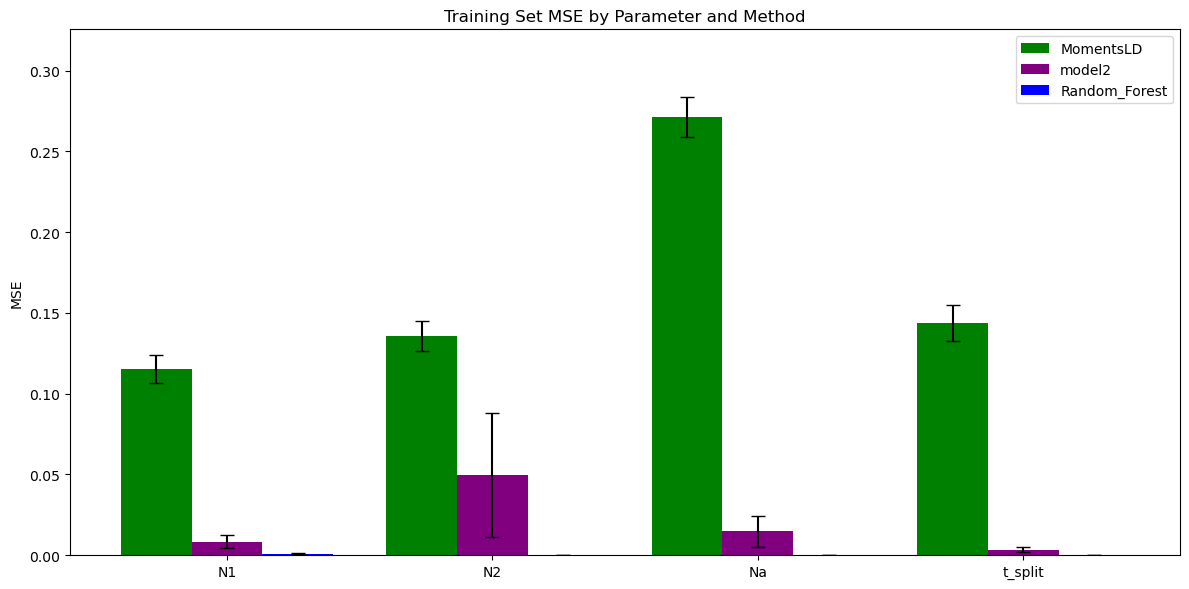

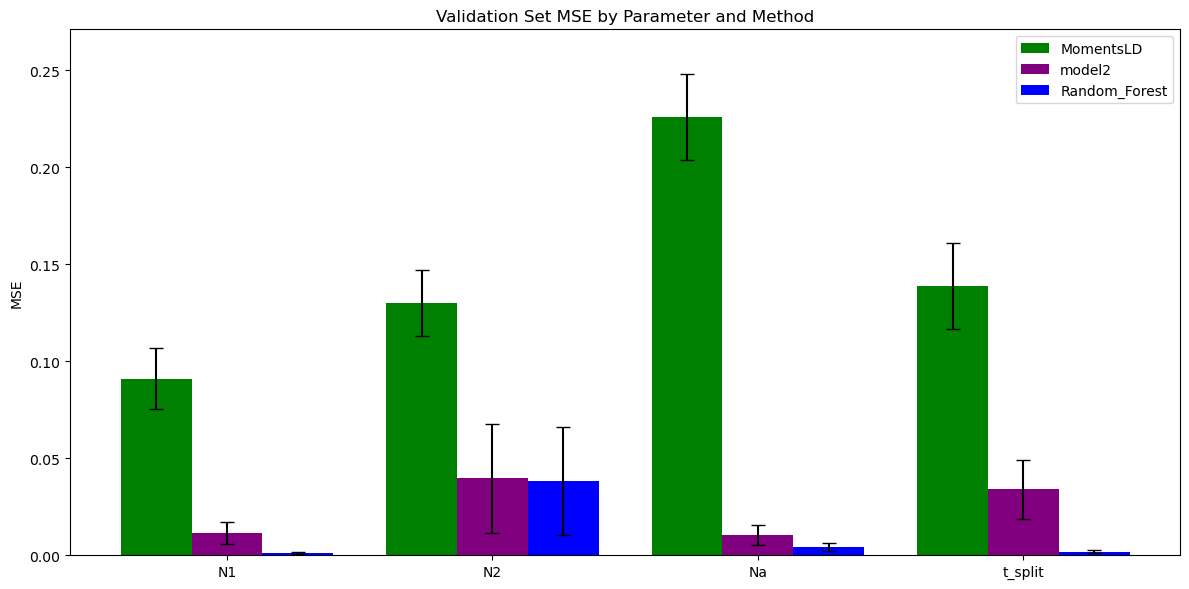

In [13]:
import matplotlib.pyplot as plt
def plot_comparison_barplot(result_df, model_names, title='MSE by Parameter and Method'):
    """
    Create grouped bar plot comparing multiple models' MSE values
    
    Parameters:
    -----------
    result_df : pandas DataFrame
        DataFrame containing MSE and std_err columns for each model
    model_names : list
        List of model names to plot
    title : str
        Title for the plot
    
    Returns:
    --------
    fig : matplotlib figure object
    """
    # Get parameter names (indices of DataFrame)
    params = result_df.index
    
    # Create grouped bar plot
    x = np.arange(len(params))
    n_models = len(model_names)
    width = 0.8 / n_models  # Adjust bar width based on number of models

    fig, ax = plt.subplots(figsize=(12, 6))

    # Define colors for each model
    colors = ['green', 'purple', 'blue', 'red', 'orange', 'brown']  # Add more colors if needed
    
    # Calculate positions for bars
    positions = np.linspace(-(width * (n_models-1)/2), width * (n_models-1)/2, n_models)
    
    # Create bars for each model
    rects = []
    for i, model_name in enumerate(model_names):
        rects.append(ax.bar(x + positions[i], 
                          result_df[model_name], 
                          width,
                          yerr=result_df[f'{model_name}_std_err'],
                          label=model_name, 
                          capsize=5, 
                          color=colors[i % len(colors)]))

    ax.set_ylabel('MSE')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(params)
    ax.legend()

    # Add some padding to the top of the plot to show error bars fully
    max_val = max(result_df[model_names].max())
    ax.set_ylim(0, max_val * 1.2)

    plt.tight_layout()
    
    return fig

# Usage example:
model_names = ['MomentsLD', 'model2', 'Random_Forest']  # Add as many models as needed

# For training data
fig_train = plot_comparison_barplot(result_df1_train, 
                                  model_names, 
                                  "Training Set MSE by Parameter and Method")
plt.show()

# For validation data
fig_val = plot_comparison_barplot(result_df1_validation, 
                                model_names, 
                                "Validation Set MSE by Parameter and Method")
plt.show()

# XGBoost 

In [14]:
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

In [15]:
experiment_directory = '/sietch_colab/akapoor/Demographic_Inference/model2_results/XGBoost/'
os.makedirs(experiment_directory, exist_ok=True)

In [16]:
# Import data
with open('/sietch_colab/akapoor/Demographic_Inference/model2_results/features_and_targets.pkl', 'rb') as f:
    features_and_targets = pickle.load(f)

In [17]:
# Define parameter distributions for random search
param_distributions = {
    'estimator__max_depth': randint(3, 10),
    'estimator__learning_rate': uniform(0.01, 0.3),
    'estimator__n_estimators': randint(100, 400),
    'estimator__subsample': uniform(0.6, 0.4),
    'estimator__colsample_bytree': uniform(0.6, 0.4),
    'estimator__min_child_weight': randint(1, 7),
    'estimator__gamma': uniform(0, 5)
}

# Create the base XGBoost regressor
# Note: We've removed early_stopping_rounds since we're using cross-validation
base_xgb = XGBRegressor(
    objective='reg:squarederror',
    tree_method='hist',
    n_jobs=-1,
    random_state=42
)

# Create the MultiOutputRegressor
multioutput_xgb = MultiOutputRegressor(base_xgb)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=multioutput_xgb,
    param_distributions=param_distributions,
    n_iter=25,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

print("Starting XGBoost parameter optimization...")

# Fit the random search
random_search.fit(
    features_and_targets['training']['features'],
    features_and_targets['training']['targets']
)

# Calculate detailed metrics for the best model
best_model = random_search.best_estimator_
train_predictions = best_model.predict(features_and_targets['training']['features'])
val_predictions = best_model.predict(features_and_targets['validation']['features'])

# Calculate MSE for each target variable
train_mse = mean_squared_error(
    features_and_targets['training']['targets'],
    train_predictions
)
val_mse = mean_squared_error(
    features_and_targets['validation']['targets'],
    val_predictions
)

results = {
    'best_model': best_model,
    'best_params': random_search.best_params_,
    'cv_score': -random_search.best_score_,
    'train_mse': train_mse,
    'validation_mse': val_mse,
    'search_results': random_search.cv_results_
}

print("\nBest parameters found:")
for param, value in random_search.best_params_.items():
    print(f"{param}: {value}")
print(f"\nBest cross-validation MSE: {-random_search.best_score_:.4f}")


Starting XGBoost parameter optimization...
Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] END estimator__colsample_bytree=0.749816047538945, estimator__gamma=4.75357153204958, estimator__learning_rate=0.22959818254342154, estimator__max_depth=7, estimator__min_child_weight=5, estimator__n_estimators=202, estimator__subsample=0.7783331011414365; total time=   0.6s
[CV] END estimator__colsample_bytree=0.6399899663272012, estimator__gamma=2.2962444598293357, estimator__learning_rate=0.11011258334170654, estimator__max_depth=5, estimator__min_child_weight=6, estimator__n_estimators=357, estimator__subsample=0.8887995089067299; total time=   1.0s
[CV] END estimator__colsample_bytree=0.815876852955632, estimator__gamma=2.9337558283192413, estimator__learning_rate=0.2995765921792414, estimator__max_depth=6, estimator__min_child_weight=4, estimator__n_estimators=140, estimator__subsample=0.718509402281633; total time=   1.5s
[CV] END estimator__colsample_bytree=0.60922497001

In [18]:
results

{'best_model': MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                             callbacks=None,
                                             colsample_bylevel=None,
                                             colsample_bynode=None,
                                             colsample_bytree=0.9442922333025374,
                                             device=None,
                                             early_stopping_rounds=None,
                                             enable_categorical=False,
                                             eval_metric=None,
                                             feature_types=None,
                                             gamma=0.03476065265595352,
                                             grow_policy=None,
                                             importance_type=None,
                                             interaction_constraints=None,
                       

In [19]:
# save the results
with open(f'{experiment_directory}/xgboost_results.pkl', 'wb') as f:
    pickle.dump(results, f)

In [20]:
train_predictions = best_model.predict(features_and_targets['training']['features'])
validation_predictions = best_model.predict(features_and_targets['validation']['features'])

In [21]:
model_obj = {}
model_obj['training'] = {}
model_obj['validation'] = {}

model_obj['training']['predictions'] = train_predictions
model_obj['validation']['predictions'] = validation_predictions

model_obj['training']['targets'] = features_and_targets['training']['targets']
model_obj['validation']['targets'] = features_and_targets['validation']['targets']

model_obj['param_names'] = [
            "Na",
            "N1",
            "N2",
            "t_split"
        ]


In [22]:
import numpy as np
import pandas as pd
def calculate_mse_df(dataset_type, linear_mdl_obj, model_name):
    """Calculate MSE and standard errors for a given dataset type (training or validation)"""
    params = linear_mdl_obj['param_names']
    mse_values = {}
    mse_errors = {}

    for i, param in enumerate(params):
        mse_values[param] = {}
        mse_errors[param] = {}
        target_values = linear_mdl_obj[dataset_type]['targets'][i]
        predictions = linear_mdl_obj[dataset_type]['predictions'][i]
        
        # Calculate MSE for each simulation
        squared_errors = (predictions - target_values) ** 2

        # Mean MSE across all simulations
        mse_values[param][f'{model_name}'] = np.mean(squared_errors)

        # Standard error of MSE across simulations
        mse_errors[param][f'{model_name}'] = np.std(squared_errors) / np.sqrt(len(squared_errors))

    # Create DataFrame
    result_df = pd.DataFrame({
        f'{model_name}': [mse_values[p][f'{model_name}'] for p in params],
        f'{model_name}_std_err': [mse_errors[p][f'{model_name}'] for p in params],
    }, index=params)
    
    return result_df

# Calculate MSE for both datasets
train_df_XGB = calculate_mse_df('training', model_obj, 'XGBoost')
val_df_XGB = calculate_mse_df('validation', model_obj, 'XGBoost')

print("Training MSE Values and Standard Errors:")
print(train_df_XGB)
print("\nValidation MSE Values and Standard Errors:")
print(val_df_XGB)

Training MSE Values and Standard Errors:
          XGBoost  XGBoost_std_err
Na       0.002365         0.001921
N1       0.006141         0.003078
N2       0.005714         0.003711
t_split  0.001370         0.000506

Validation MSE Values and Standard Errors:
          XGBoost  XGBoost_std_err
Na       0.002398         0.001520
N1       0.004029         0.001350
N2       0.029562         0.017620
t_split  0.005330         0.002254


Load the linear model and calculate the same df

In [23]:
with open('/sietch_colab/akapoor/Demographic_Inference/model2_results/linear_mdl_obj.pkl', 'rb') as f:
    linear_mdl_obj = pickle.load(f)

In [24]:
# Calculate MSE for both datasets
train_df_mdl2 = calculate_mse_df('training', linear_mdl_obj, 'model2')
val_df_mdl2 = calculate_mse_df('validation', linear_mdl_obj, 'model2')

print("Training MSE Values and Standard Errors:")
print(train_df_mdl2)
print("\nValidation MSE Values and Standard Errors:")
print(val_df_mdl2)

Training MSE Values and Standard Errors:
           model2  model2_std_err
Na       0.014813        0.009641
N1       0.008425        0.004305
N2       0.049813        0.038381
t_split  0.003485        0.001398

Validation MSE Values and Standard Errors:
           model2  model2_std_err
Na       0.010366        0.004936
N1       0.011478        0.005526
N2       0.039591        0.028196
t_split  0.034043        0.015178


In [25]:
import pandas as pd
momentsld_train = pd.read_csv('/sietch_colab/akapoor/Demographic_Inference/sims_pretrain_5000_sims_inference_1_seed_42_num_replicates_3_top_values_2/mean_values_preprocess_train.csv', index_col = 0)
momentsld_validation = pd.read_csv('/sietch_colab/akapoor/Demographic_Inference/sims_pretrain_5000_sims_inference_1_seed_42_num_replicates_3_top_values_2/mean_values_preprocess_validation.csv', index_col = 0)
# Using str.contains()
momentsLD_train = momentsld_train.loc[:, momentsld_train.columns.str.contains('MomentsLD')]
momentsLD_validation = momentsld_validation.loc[:, momentsld_validation.columns.str.contains('MomentsLD')]

# Merge dataframes horizontally
result_df1_train = pd.concat([momentsLD_train, train_df_RF, train_df_XGB], axis=1)
result_df1_validation = pd.concat([momentsLD_validation, val_df_RF, val_df_XGB], axis=1)

result_df1_train = pd.concat([result_df1_train, train_df_mdl2], axis = 1)
result_df1_validation = pd.concat([result_df1_validation, val_df_mdl2], axis = 1)


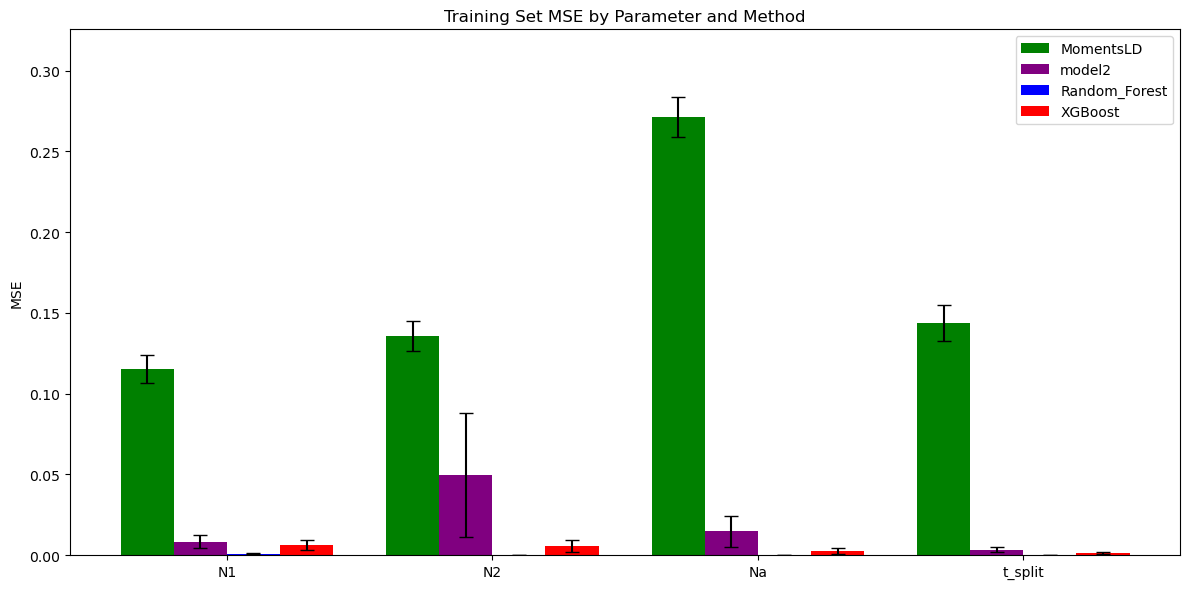

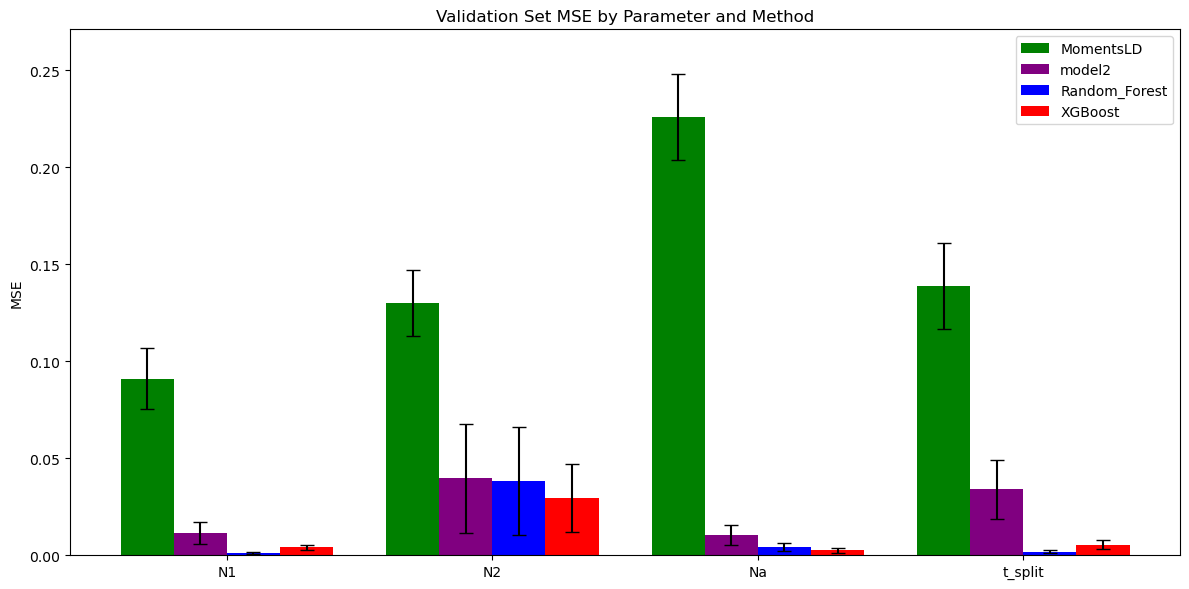

In [26]:
import matplotlib.pyplot as plt
def plot_comparison_barplot(result_df, model_names, title='MSE by Parameter and Method'):
    """
    Create grouped bar plot comparing multiple models' MSE values
    
    Parameters:
    -----------
    result_df : pandas DataFrame
        DataFrame containing MSE and std_err columns for each model
    model_names : list
        List of model names to plot
    title : str
        Title for the plot
    
    Returns:
    --------
    fig : matplotlib figure object
    """
    # Get parameter names (indices of DataFrame)
    params = result_df.index
    
    # Create grouped bar plot
    x = np.arange(len(params))
    n_models = len(model_names)
    width = 0.8 / n_models  # Adjust bar width based on number of models

    fig, ax = plt.subplots(figsize=(12, 6))

    # Define colors for each model
    colors = ['green', 'purple', 'blue', 'red', 'orange', 'brown']  # Add more colors if needed
    
    # Calculate positions for bars
    positions = np.linspace(-(width * (n_models-1)/2), width * (n_models-1)/2, n_models)
    
    # Create bars for each model
    rects = []
    for i, model_name in enumerate(model_names):
        rects.append(ax.bar(x + positions[i], 
                          result_df[model_name], 
                          width,
                          yerr=result_df[f'{model_name}_std_err'],
                          label=model_name, 
                          capsize=5, 
                          color=colors[i % len(colors)]))

    ax.set_ylabel('MSE')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(params)
    ax.legend()

    # Add some padding to the top of the plot to show error bars fully
    max_val = max(result_df[model_names].max())
    ax.set_ylim(0, max_val * 1.2)

    plt.tight_layout()
    
    return fig

# Usage example:
model_names = ['MomentsLD', 'model2', 'Random_Forest','XGBoost']  # Add as many models as needed

# For training data
fig_train = plot_comparison_barplot(result_df1_train, 
                                  model_names, 
                                  "Training Set MSE by Parameter and Method")
plt.show()

# For validation data
fig_val = plot_comparison_barplot(result_df1_validation, 
                                model_names, 
                                "Validation Set MSE by Parameter and Method")
plt.show()